# Lab 5b - K-Means

This notebook introduces the second of two Classic Clustering Methods, i.e., K-Means as a *partitioning clustering* method. Special aspects considered include the visualization and spatial analysis of the cluster results.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We will consider k-means as an example of partitioning methods.

The empirical illustration is based on the material in Chapter 6 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to the usual numpy, geopandas and matplotlib, we also import several specialized packages from scikit-learn. Specifically, to carry out variable standardization we import `StandardScaler` from `sklearn.preprocessing`. We compute principal components with `PCA` from `sklearn.decomposition`. The specific clustering method is `KMeans` from `sklearn.cluster`. To characterize the solution in K-Means, we apply `silhouette_samples` and `silhouette_score` from `sklearn.metrics`.

Finally, to implement some of the *spatialization* of these methods, we import several functions from the `spatial_cluster_course` utility module (this requires that the latest version of the file spatial_cluster_course.py is in the current Python path):
- `cluster_stats`
- `cluster_map`
- `cluster_center`
- `cluster_fit`
- `elbow_plot`
- `plot_silhouette`

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from spatial_cluster_course import cluster_stats,cluster_map, cluster_center, cluster_fit, elbow_plot, plot_silhouette

### Load data

For this exercise, we will use a data set on socio-economic variables for Chicago census tracts contained in the Chicago-SDOH sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Chi-SDOH/

The following files will be used:
- **Chicago_SDOH.shp,shx,dbf,prj**: shape file (four files) for 971 census tracts

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [ ]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Chicago community area data:
dfs = gpd.read_file(path+"Chi-SDOH/Chi-SDOH.shp")
print(dfs.shape)
dfs.head(3)

(791, 56)


,OBJECTID,Shape_Leng,Shape_Area,TRACTCE10,geoid10,commarea,ChldPvt14,EP_CROWD,EP_UNINSUR,EP_MINRTY,...,ForclRt,EP_MUNIT,EP_GROUPQ,SchHP_Mi,BrownF_Mi,card,cpval,COORD_X,COORD_Y,geometry
0,1,22777.477721,2.119089e+07,842400.0,1.703184e+10,44.0,30.2,2.0,18.6,100.0,...,0.0,6,0.0,0.323962,0.825032,0.0,0.0,1176.183467,1849.533205,"POLYGON ((1177796.742 1847712.428, 1177805.261..."
1,2,16035.054986,8.947394e+06,840300.0,1.703184e+10,59.0,38.9,4.8,25.2,85.9,...,0.0,2,0.0,2.913039,0.833580,0.0,0.0,1161.787888,1882.078567,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
2,3,15186.400644,1.230614e+07,841100.0,1.703184e+10,34.0,40.4,4.9,32.1,95.6,...,0.0,42,0.1,1.534987,0.245875,0.0,0.0,1174.481923,1889.069999,"POLYGON ((1176041.55 1889791.988, 1176042.377 ..."


In [4]:
# the full set of variables
print(list(dfs.columns))

['OBJECTID', 'Shape_Leng', 'Shape_Area', 'TRACTCE10', 'geoid10', 'commarea', 'ChldPvt14', 'EP_CROWD', 'EP_UNINSUR', 'EP_MINRTY', 'Ovr6514P', 'EP_AGE17', 'EP_DISABL', 'EP_NOHSDP', 'EP_LIMENG', 'EP_SNGPNT', 'Pov14', 'EP_PCI', 'Unemp14', 'EP_NOVEH', 'FORCLRISK', 'HealthLit', 'CarC14P', 'CAR', 'NOCAR', 'CTA14P', 'CTA', 'CmTm14', 'Undr514P', 'Wht14P', 'WHT50PCT', 'Wht', 'Blk14P', 'BLCK50PCT', 'Blk', 'Hisp14P', 'HISP50PCT', 'Hisp', 'Pop2014', 'PDENS14', 'MEANMI_07', 'MEANMI_11', 'MEANMI_14', 'FACHANGE', 'PCRIMERT15', 'VCRIMERT15', 'ForclRt', 'EP_MUNIT', 'EP_GROUPQ', 'SchHP_Mi', 'BrownF_Mi', 'card', 'cpval', 'COORD_X', 'COORD_Y', 'geometry']


#### Selecting variables and checking their correlation

Following Section 6.3 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/implementation-4.html), the variables in our Chicago census tract sample data set are a close match to the variables identified in Kolak et al. (2020) in an analysis that includes all U.S. census tracts. It consists of 16 variables:

| Column Name | Description                                                                 |
|-------------|-----------------------------------------------------------------------------|
| EP_MINRTY   | Minority population share                                                 |
| Ovr6514P    | Population share aged > 65                                                |
| EP_AGE17    | Population share aged < 18                                                |
| EP_DISABL   | Disabled population share                                                 |
| EP_HOHSDP   | No high school                                                            |
| EP_LIMENG   | Limited English proficiency                                               |
| EP_SNGPNT   | Percentage of single parent households                                    |
| Pov14       | Poverty rate                                                              |
| EP_PCI      | Per capita income                                                         |
| Unemp14     | Unemployment rate                                                         |
| EP_UNINSUR  | Percent without health insurance                                          |
| EP_CROWD    | Percent crowded housing                                                   |
| EP_NOVEH    | Percent without a car                                                     |
| ChldPvt14   | Child poverty rate                                                        |
| HealthLit   | Health literacy index                                                     |
| FORCLRISK   | Foreclosure risk                                                          |


We start by computing simple descriptive statistics by applying the `describe` method to the subset of the data frame that contains the selected variables. The results are rounded to two decimals.

In [5]:
varlist = ['EP_MINRTY','Ovr6514P','EP_AGE17','EP_DISABL',
           'EP_NOHSDP','EP_LIMENG','EP_SNGPNT','Pov14',
           'EP_PCI','Unemp14','EP_UNINSUR','EP_CROWD',
           'EP_NOVEH','ChldPvt14','HealthLit','FORCLRISK']
data_cluster = dfs[varlist]

round(data_cluster.describe(),2)

,EP_MINRTY,Ovr6514P,EP_AGE17,EP_DISABL,EP_NOHSDP,EP_LIMENG,EP_SNGPNT,Pov14,EP_PCI,Unemp14,EP_UNINSUR,EP_CROWD,EP_NOVEH,ChldPvt14,HealthLit,FORCLRISK
count,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00,791.00
mean,69.55,10.74,22.60,11.26,19.20,7.84,13.00,20.13,27956.98,15.57,18.48,4.76,26.89,31.10,242.53,23.49
std,30.27,6.02,8.54,5.54,13.58,9.86,9.79,14.78,19592.21,10.09,9.05,4.80,14.86,22.36,14.58,23.77
min,6.20,0.70,1.10,0.40,0.00,0.00,0.00,0.00,3077.00,0.60,1.00,0.00,0.00,0.00,125.86,0.20
25%,42.00,6.50,17.55,7.10,8.90,0.00,5.10,7.65,14679.00,7.90,11.70,1.05,15.00,11.55,234.16,5.54
50%,80.80,9.50,23.30,10.20,17.40,3.00,11.10,17.80,21216.00,13.00,17.90,3.30,24.20,29.80,245.16,13.56
75%,97.90,13.60,28.45,15.35,27.50,14.00,19.20,29.95,33835.50,20.70,24.45,7.05,37.85,48.20,252.58,30.84
max,100.00,47.00,50.70,34.40,65.40,47.00,56.50,73.10,127743.00,51.80,45.00,25.80,79.20,93.60,271.90,100.00


Before proceeding further, we extract the number of observations and compute the scaling factor $\sqrt{(n-1)/n}$ needed to replicate the results from `GeoDa` (see hierarchical clustering notebook).

In [6]:
n = data_cluster.shape[0]
nn = (n-1.0)/n

## Clustering with Dimension Reduction

In practice, when many variables are involved, it is often more efficient to carry out the clustering exercise after a dimension reduction. More specifically, the clustering is applied to the main principal components of the original variables.

We first transform the variables using `StandardScaler`. In order to retain compatibility with the results for `GeoDa`, we rescale those results by $\sqrt{(n-1)/n}$ and then apply the `PCA().fit()` method. The factor loadings are in the resulting `components_` attribute.

In [7]:
X0 = StandardScaler().fit_transform(data_cluster)
X1 = X0 * nn
pca_res = PCA().fit(X1)
pca_res.components_

array([[ 0.33824863, -0.02767885,  0.29159216,  0.19532335,  0.28473044,
         0.10177461,  0.3168122 ,  0.32666508, -0.32245438,  0.28719305,
         0.25713029,  0.22366353,  0.11580138,  0.31762617, -0.01704885,
         0.21435943],
       [-0.06920095, -0.32122211,  0.10745714, -0.36333146,  0.28673661,
         0.49749526, -0.07628474, -0.10662782, -0.04344009, -0.25805376,
         0.2914494 ,  0.33241983, -0.29503893, -0.09891616, -0.0204966 ,
        -0.20096159],
       [ 0.12996788,  0.60193803, -0.07823625,  0.30737561,  0.1736577 ,
         0.23359596, -0.21902106, -0.2687673 , -0.18572297, -0.05220259,
         0.10643154, -0.03100825, -0.36802528, -0.20257751,  0.06986895,
         0.29048044],
       [-0.06484105,  0.19858591, -0.27120191,  0.19752884,  0.12097044,
         0.1780976 , -0.16748035,  0.11172722,  0.06180415, -0.08390976,
         0.16760664,  0.17480623,  0.49277773,  0.08114224,  0.54731901,
        -0.37205383],
       [-0.01771277, -0.15430746,  0

The results replicate the values in Figure 6.12 of the Spatial Clustering book, except that the loadings on each principal component are represented by a row. The share of the explained variance is given by the `explained_variance_ratio` attribute. This shows how the first four components explain 77.4% of the total variance.

In [8]:
pca_res.explained_variance_ratio_

array([0.44343332, 0.17653146, 0.08618913, 0.06735124, 0.06136565,
       0.0332085 , 0.0266497 , 0.02037288, 0.01808922, 0.01557287,
       0.01249381, 0.01150607, 0.00963066, 0.00757845, 0.00600901,
       0.00401802])

The explained variance of each component is included in the `explained_variance_` attribute. These are also the eigenvalues of $X'X$. We use the Kaiser criterion and select the four principal components with an eigenvalue larger than one.

In [9]:
pca_res.explained_variance_

array([7.08596352, 2.82093259, 1.37728273, 1.07625754, 0.98060908,
       0.53066427, 0.42585611, 0.32555396, 0.28906166, 0.24885099,
       0.19964831, 0.18386442, 0.15389582, 0.12110185, 0.09602261,
       0.06420698])

We next replicate the example in the Spatial Clustering book and carry out the clustering exercise on these four principal components. These are contained in the `transform` attribute, from which we extract the first four columns and turn them into a data frame. For the cluster analysis, we first need to standardize the principal components with `StandardScaler`. We also rescale them by `nn` to conform to the `GeoDa` results.

In [10]:
pca_vars = pca_res.transform(X1)[:,0:4]
pca_df = pd.DataFrame(pca_vars,columns=["PC1","PC2","PC3","PC4"])
XX = StandardScaler().fit_transform(pca_df)
X = XX * nn

## K-Means Principle

K-Means is a partitioning clustering method that starts with an initial solution and moves forward by means of *iterative relocation* to find a better solution. The objective function is to find an allocation (an *encoding*) of each observation to one of the $k$ clusters that minimizes the within cluster dissimilarity (or, maximizes the between cluster dissimilarity). This corresponds to the sum of squared deviations from the mean in each cluster, i.e., the within sum of squared errors.

The iterative relocation computes a new set of cluster centers after each move and then allocates observations to their nearest center. This is the classic *Lloyds* algorithm, a special case of EM (expectation, maximization). It stops when no further improvement is possible, but this does *not* guarantee that a global optimum is reached. In fact, the algorithm can easily get stuck in *local* optima.

A critical aspect of this process is the initial starting solution. Since all further moves proceed from this initial assignment, the end result critically depends on it. To address this sensitivity, typically several different starting points are compared, each randomly generated.

We use `sklearn.cluster.KMeans` to illustrate this method. It works in the same way as the other scikit-learn methods: first an instance of the class is created, to which then a `fit` method is applied for the given data set (`X`). The default arguments for a KMeans instance are `n_clusters=8`, for the number of clusters, `init="k-means++"` for the KMeans++ initialization method, and `random_state`, a random number seed. Whereas the default is `None`, this should be set to an integer value to obtain reproducible results. However, it should be kept in mind that the initial starting solution will depend on this random number and it should be varied to assess the sensitivity of the results. Finally, we also set `n_init=150` to retain compatibility with `GeoDa` (the number of initial solutions that are evaluated).

The final cluster allocation is contained in the usual `labels_` attribute, which can be summarized and visualized using the helper functions `cluster_stats`, `cluster_center`, `cluster_fit` and `cluster_map`, as illustrated in the hierarchical clustering notebook.

In addition, we also try to find the best value for $k$ by means of an *elbow plot* and assess the solution by means of a *silhouette plot*.

## K-Means Solution

### K-means++

In scikit-learn, the default starting solution is obtained with KMeans++, which is an adjusted random allocation. The equal probabilities from a pure random allocation are adjusted in function of the distance to the remaining points, so as to obtain a more even allocation.

We illustrate this method for our principal components with 8 clusters. The only argument that needs to be set is the random number seed. We list the result by means of our `cluster_stats` helper function.

In [11]:
n_clusters = 8
kmeans1 = KMeans(n_clusters=n_clusters, n_init=150, random_state=1234567).fit(X) 
cluster_labels1 = kmeans1.labels_
cluster_stats(cluster_labels1)

,Labels,Cardinality
0,0,65
1,1,154
2,2,116
3,3,131
4,4,89
5,5,44
6,6,77
7,7,115


The cluster centers are given by the `cluster_center` helper function. This is not as useful as before since it is expressed in terms of the principal components. However, it can still be used in visualizations by means of a PCP or conditional box plot.

In [12]:
c_means,c_medians = cluster_center(pca_df,cluster_labels1)
print("Mean Centers \n",np.round(c_means,2))
print("Median Centers \n",np.round(c_medians,2))

Mean Centers 
           PC1   PC2   PC3   PC4
cluster                        
0       -2.39 -0.35 -0.91  1.29
1        2.98 -1.25 -1.09 -0.05
2       -1.28  0.61  0.55  0.18
3        2.02  2.69  0.38  0.30
4        1.24 -1.98  1.41 -0.63
5       -1.10 -1.94  1.35  1.81
6       -1.01  0.40  0.54 -1.47
7       -3.51  0.21 -0.99 -0.40
Median Centers 
           PC1   PC2   PC3   PC4
cluster                        
0       -2.61 -0.33 -0.84  1.14
1        3.11 -1.31 -0.99 -0.06
2       -1.16  0.56  0.51  0.16
3        1.96  2.62  0.43  0.40
4        1.21 -2.01  1.42 -0.56
5       -1.08 -1.89  1.11  1.84
6       -1.26  0.47  0.62 -1.30
7       -3.68  0.27 -1.05 -0.39


The fit is given by `cluster_fit`. There are minor differences with the example in `GeoDa`, due to slightly different random initialization. However, the BSS/TSS ratio is the same, at 0.685.

In [13]:
clusfit = cluster_fit(data=pca_df,clustlabels=cluster_labels1,
                 n_clusters=n_clusters)


Total Sum of Squares (TSS): 3164.0
Within-cluster Sum of Squares (WSS) for each cluster: [ 78.965 241.471 103.346 173.274 103.375 101.08  103.763  91.174]
Total Within-cluster Sum of Squares (WSS): 996.447
Between-cluster Sum of Squares (BSS): 2167.553
Ratio of BSS to TSS: 0.685


Finally, `cluster_map` provides a view of the spatial pattern of the solution.

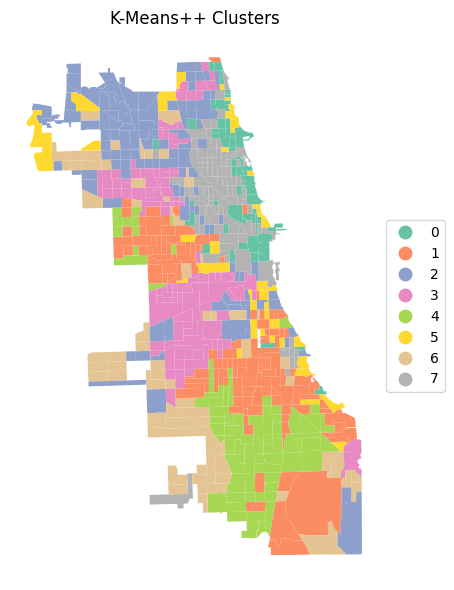

In [14]:
cluster_map(dfs, cluster_labels1, figsize=(6,6), title="K-Means++ Clusters", cmap='Set2')

### Random Initial Allocation

We also illustrate random initial allocation by setting the argument `init = "random"`. We only summarize the results with the cluster allocation and measures of fit. The resulting clusters are slightly different, but the overall BSS/TSS ratio is the same as before. Further experimenting with random seeds is recommended, but not further considered here.

In [15]:
kmeans2 = KMeans(n_clusters=n_clusters, init = 'random', n_init=150, random_state=1234567).fit(X) 
cluster_labels2 = kmeans2.labels_
cluster_stats(cluster_labels2)

,Labels,Cardinality
0,0,127
1,1,116
2,2,60
3,3,89
4,4,154
5,5,44
6,6,86
7,7,115


In [16]:
clusfit = cluster_fit(data=pca_df,clustlabels=cluster_labels2,
                 n_clusters=n_clusters)


Total Sum of Squares (TSS): 3164.0
Within-cluster Sum of Squares (WSS) for each cluster: [166.257 104.333  69.919 103.375 241.471 101.08  118.905  91.07 ]
Total Within-cluster Sum of Squares (WSS): 996.409
Between-cluster Sum of Squares (BSS): 2167.591
Ratio of BSS to TSS: 0.685


## Elbow Plot

So far, we have taken the number of clusters as a given. However, unless a specific policy issue dictates the number, this is typically not the case. As the number of clusters goes up, the WSS will necessarily decline. A *best* number of clusters can be chosen based on the pattern in this decline, by means of the so-called *elbow plot*. This plot visualizes the decline in WSS (or, alternativatively, the increase in BSS) with an increase in $k$. A *kink* in the elbow plot would suggest a point at which increasing $k$ is not worth the decline in WSS. In practice, this is not always that straightforward. The k-means object contains the total WSS in the `inertia_` attribute.

We illustrate an elbow plot by running K-Means in a loop for values of n_clusters going from 2 to 20 in a simple line plot. This functionality is also encapsulated in the helper function `elbow_plot`.

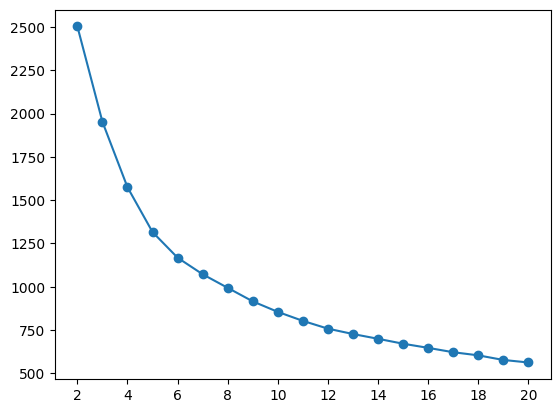

In [17]:
inertia = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, n_init=150, random_state=1234567).fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 21), inertia, marker='o')
plt.xticks(range(2, 21, 2))
plt.show()

The plot does not show much of a *kink* in this application. This is actually (unfortunately) the case in many empirical instances. In our illustration, the improvement in WSS seems to decline starting at $k = 6$.

The helper function `elbow_plot` takes as arguments the standardized data and the maximum number of clusters, `max_clusters` (default 20), as well as some arguments to customize the K-Means algorithm (e.g., `init`, `n_init`, `random_state`). We illustrate this below.

With `X` as the standardized data and all the other arguments set to their default values, the elbow plot is invoked as `elbow_plot(X)`. The result is identical to the graph above.

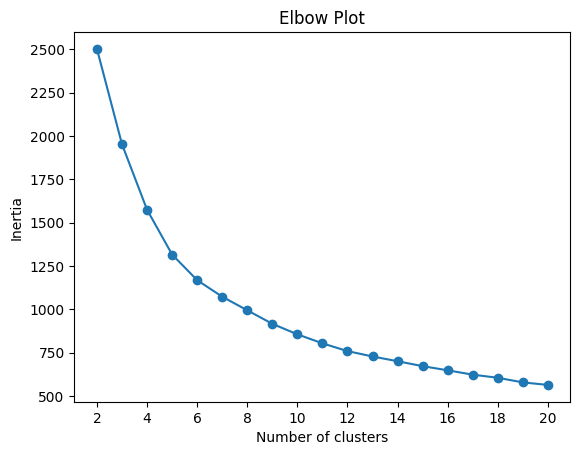

In [18]:
elbow_plot(X)

## Silhouette Score

A measure of the degree of effective separation between clusters is given by the so-called *silhouette* coefficient. For each observation assigned to a cluster, this is based on the average distance to the other cluster members (say, $nn_i$) as well as the average distance to the nearest member in a different cluster (say, $nn_j$). The silhouette score is then the ratio $(nn_j - nn_i)/max(nn_i,nn_j)$. It varies between +1 (densest) and -1 (least dense). The average of this score over all observations is an overall measure of separation, i.e., the closer this value is to +1, the better the cluster separation.

Scikit-learn computes the observation-specific silhouette values in `sklearn.metrics.silhouette_samples`. This takes as arguments the standardized data set (`X`) and the cluster labels. In our example, this yields an array with 791 values. The mean of this array is the same value as obtained with `sklearn.metrics.silhouette_score`.

In [19]:
sample_silhouette_values = silhouette_samples(X, cluster_labels1)
print(sample_silhouette_values.shape)
print("Mean silhouette value ",np.round(sample_silhouette_values.mean(),4))
print("Silhouette Score ",np.round(silhouette_score(X, cluster_labels1),4))

(791,)
Mean silhouette value  0.2725
Silhouette Score  0.2725


The typical application for silhouette scores is to plot them as a horizontal bar chart for each cluster, showing the score for each individual observation. For 791 observations, this is not going to be too practical.

We illustrate the general idea for cluster with label 5, which has only 44 observations. To this effect, we extract the observation label from the initial data frame, then create an array with the silhouette values, ID and cluster label and extract only those observations with cluster label = 5. We then sort on the silhouette values and create two arrays with respectively the observation IDs and the silhouette values in sorted order.

These arrays are passed to the `barh` plot with `y` as the sequence of IDs and `width` as the actual value of the silhouette score, in a bare bones graph. 

In [94]:
id = np.array(dfs['OBJECTID'])
sil = np.stack((sample_silhouette_values,id,cluster_labels1),axis=1)
silclus = (sil[:,2] == 5)
clus = sil[silclus,:]
sorted_indices = np.argsort(clus[:,0])
sortclus = clus[sorted_indices,:]
silvals = clus[sorted_indices,0]
sil_labels = clus[sorted_indices,1]
sil_labels = sil_labels.astype(int)

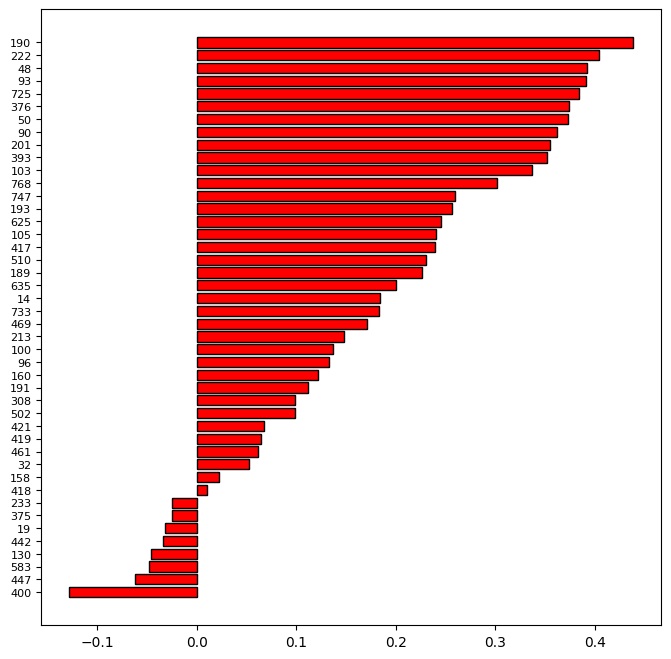

In [96]:
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(
    np.arange(len(silvals)),silvals,
    color = "red",
    edgecolor="black"
)
ax.set_yticks(np.arange(len(sil_labels)))
ax.set_yticklabels(sil_labels, fontsize=8) 
plt.show()

The bar plot shows the evolution of the silhouette scores from a maximum of 0.438 to a minimum of -0.128. The labels on the left-hand side correspond with the ID numbers of the census tracts. The negative values for tracts 233 to 400 at the bottom of the graph indicate tracts that do not fit the given cluster very well. These may be candidates to be moved over to a different cluster.

The `plot_silhouette` helper function does all the sorting and labeling for a complete silhouette plot. As mentioned, this is only practical for smaller data sets. For our 791 observations, it is a bit of a stretch, but can still be accomplished be setting the `figsize = (10,60)`. For larger data sets such as these, a better approach would be to create a silhouette for each cluster separately, as illustrated above.

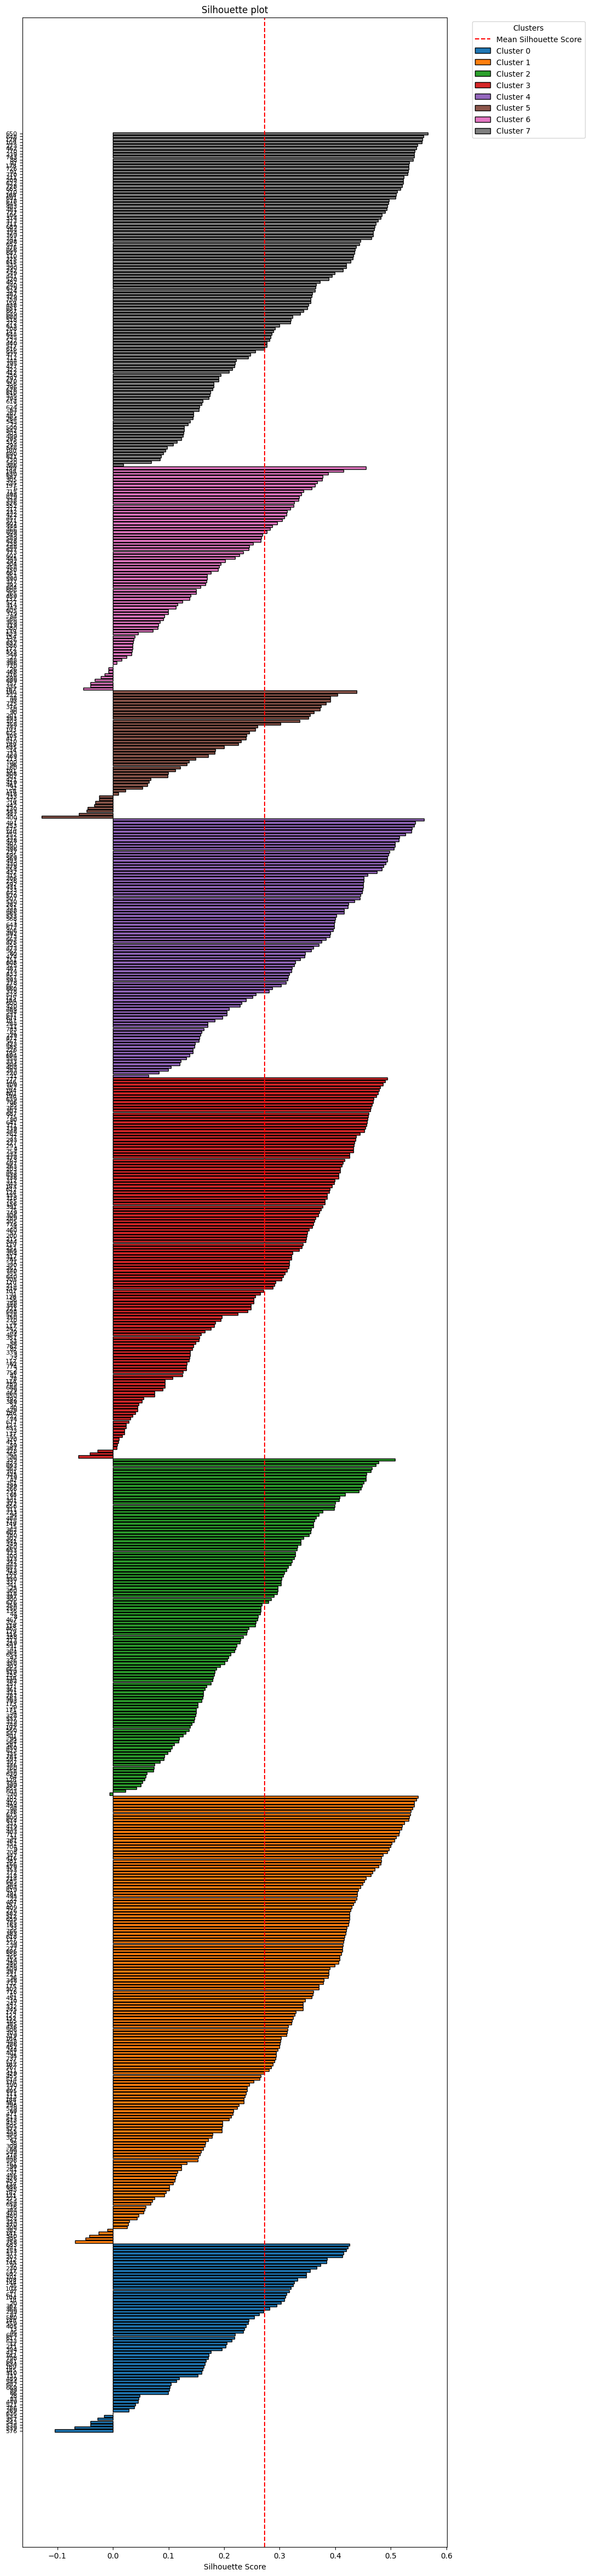

In [26]:
plot_silhouette(sample_silhouette_values, dfs['OBJECTID'], cluster_labels1,
                 title="Silhouette plot",figsize= (10,60))